In [1]:
import numpy as np
import pandas as pd
from pandas.io import sql
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pylab import rcParams

In [2]:
%load_ext dotenv
%dotenv ../.env

In [3]:
cnx = create_engine(os.getenv('EDMDB'))

Are there any invalid proxcode values on PLUTO? There are some NULL values.

In [4]:
proxcode_counts = pd.read_sql_query('''SELECT "ProxCode", COUNT(*)
FROM dcp.pluto202
GROUP BY "ProxCode";''', cnx)
proxcode_counts

,ProxCode,count
0,0,141749
1,1,313774
2,2,200383
3,3,200940
4,None,375


#### Part 1: ProxCode = '2' or '3' (Attached or Semi-Attached Buildings)

In [5]:
sql.execute('''DROP TABLE IF EXISTS dcp.buildings_23;
DROP TABLE IF EXISTS dcp.lot23_no_neighboring_bldg;
DROP TABLE IF EXISTS dcp.lot23_no_neighboring_bldg_1ft;
DROP TABLE IF EXISTS dcp.lot23_neighboring_bldg_1ft;
DROP TABLE IF EXISTS dcp.buildings_1;
DROP TABLE IF EXISTS dcp.lot1_bldg;
DROP TABLE IF EXISTS dcp.lot1_neighboring_bldg;''', cnx)

Get buildings and geometries for lots marked as attached or semi-attached. Limit analysis to those lots having only one building.

In [6]:
sql.execute('''CREATE TABLE dcp.buildings_23 AS
    SELECT CAST(p."BBL" AS TEXT) AS bbl, bin, f.geom as building_geom, p.geom as lot_geom
    FROM dcp.bldg_footprints f, dcp.pluto202 p
    WHERE f.mpluto_bbl = CAST(p."BBL" AS TEXT)
    AND "ProxCode" IN ('2', '3')
    AND "NumBldgs" = 1;
CREATE INDEX lot_geom_idx
  ON dcp.buildings_23
  USING GIST (lot_geom);
CREATE INDEX building_geom_idx
  ON dcp.buildings_23
  USING GIST (building_geom);
''', cnx)
buildings_23 = pd.read_sql_query('''SELECT * FROM dcp.buildings_23;''', cnx)
buildings_23.shape[0]

331926

Get building footprints for lots whose ProxCode is either 'attached' or 'semi-attached', yet have no buildings abutting them. Note that ST_Intersects seemed to work better here than ST_Touches; I'm not sure why. Put results in tables so you have the option of importing them to shapefiles.

In [7]:
sql.execute('''CREATE TABLE dcp.lot23_no_neighboring_bldg AS
SELECT b1.bbl, b1.bin, b1.building_geom, b1.lot_geom, COALESCE(x.count,0) AS count
FROM dcp.buildings_23 b1
LEFT JOIN (
	SELECT b1.bbl as bbl, COUNT(*) AS count
	FROM dcp.bldg_footprints b2, dcp.buildings_23 b1
	WHERE ST_Intersects(b2.geom, b1.building_geom)
	AND b2.mpluto_bbl <> b1.bbl
	AND b2.bin <> b1.bin
	GROUP BY b1.bbl
) x
ON b1.bbl = x.bbl
WHERE COALESCE(x.count,0) = 0;''', cnx)

5477 of 331926 buildings have no abutting building even if they are characterized as attached or semi attached. This is about 1.6%.

In [8]:
lot23_no_neighboring_bldg = pd.read_sql_query('''SELECT * FROM dcp.lot23_no_neighboring_bldg;''', cnx)
lot23_no_neighboring_bldg.shape[0]

5477

Now get only those buildings that don't have another building within one foot.

In [9]:
sql.execute('''CREATE TABLE dcp.lot23_no_neighboring_bldg_1ft AS
SELECT l.*
FROM dcp.lot23_no_neighboring_bldg l
WHERE l.bbl NOT IN (
SELECT a.bbl
    FROM dcp.lot23_no_neighboring_bldg a, dcp.bldg_footprints b
    WHERE ST_DWithin(a.building_geom, b.geom, 1)
    AND a.bin <> b.bin
    AND ST_Distance(a.building_geom, b.geom) > 0)
''', cnx)
lot23_no_neighboring_bldg_1ft = pd.read_sql_query('''SELECT * FROM dcp.lot23_no_neighboring_bldg_1ft;''', cnx)
lot23_no_neighboring_bldg_1ft.shape[0]

4169

Get the buildings that have a neighboring building within 1 foot

In [10]:
sql.execute('''CREATE TABLE dcp.lot23_neighboring_bldg_1ft AS
SELECT l.*
FROM dcp.lot23_no_neighboring_bldg l
WHERE l.bbl IN (
SELECT a.bbl
    FROM dcp.lot23_no_neighboring_bldg a, dcp.bldg_footprints b
    WHERE ST_DWithin(a.building_geom, b.geom, 1)
    AND a.bin <> b.bin
    AND ST_Distance(a.building_geom, b.geom) > 0)
''', cnx)
lot23_neighboring_bldg_1ft = pd.read_sql_query('''SELECT * FROM dcp.lot23_neighboring_bldg_1ft;''', cnx)
lot23_neighboring_bldg_1ft.shape[0]

1308

Break out counts by borough

In [11]:
boro_breakout23 = pd.read_sql_query('''SELECT "Borough", COUNT(*)
FROM dcp.lot23_no_neighboring_bldg l, dcp.pluto202 p
WHERE l.bbl = CAST(p."BBL" AS TEXT)
GROUP BY "Borough";''', cnx)
boro_breakout23

,Borough,count
0,BK,1868
1,BX,859
2,MN,461
3,QN,1442
4,SI,847


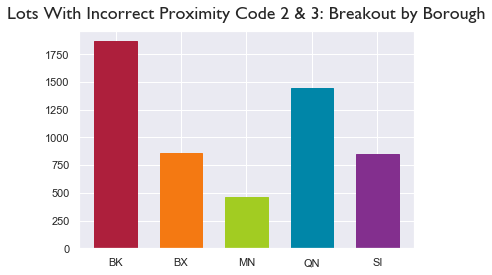

In [12]:
rcParams['figure.figsize'] = 6, 4
xlist = boro_breakout23['Borough'].to_list()
ylist = boro_breakout23['count'].to_list()
barlist=plt.bar(xlist, ylist, width=.65)
barlist[0].set_color('#ad1f3c')
barlist[1].set_color('#f47912')
barlist[2].set_color('#a2cc22')
barlist[3].set_color('#0086a8')
barlist[4].set_color('#832f8e')
plt.title('Lots With Incorrect Proximity Code 2 & 3: Breakout by Borough', fontsize=18, fontname='Gill Sans', pad=12)
plt.show()

Break out counts by land use code

In [13]:
landuse_breakout23 = pd.read_sql_query('''SELECT "LandUse", COALESCE(def, 'NULL') AS def, COUNT(*)
FROM dcp.lot23_no_neighboring_bldg l, dcp.pluto202 p
LEFT JOIN dcp.landuse_definitions d
ON p."LandUse" = d.landuse
WHERE l.bbl = CAST(p."BBL" AS TEXT)
GROUP BY "LandUse", def''', cnx)
landuse_breakout23

,LandUse,def,count
0,01,One and Two Family Buildings,2714
1,02,Multi-Family Walkup Buildings,1204
2,03,Multi-Family Elevator Buildings,316
3,04,Mixed Residential and Commercial,536
4,05,Commercial and Office,337
5,06,Industrial and Manufacturing,122
6,07,Transportation and Utility,42
7,08,Public Facilities and Institutions,152
8,09,Open Space and Outdoor Recreation,4
9,10,Parking Facilities,46


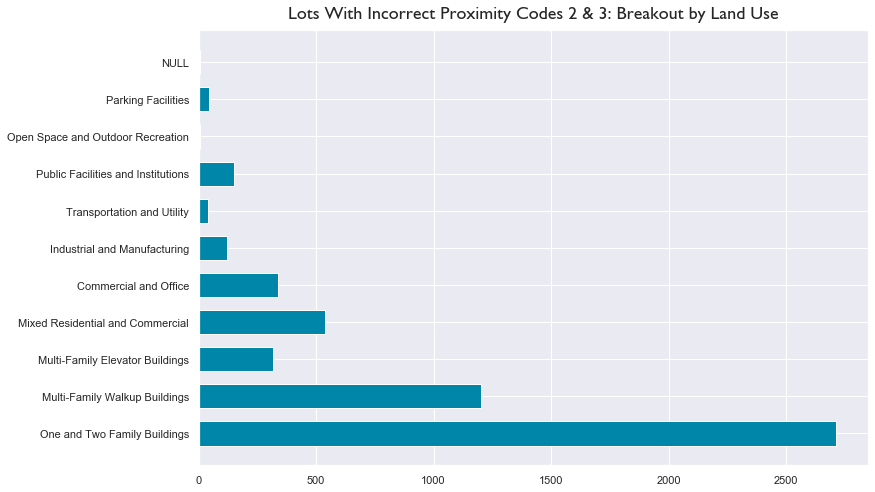

In [14]:
rcParams['figure.figsize'] = 12, 8
xlist = landuse_breakout23['def'].to_list()
ylist = landuse_breakout23['count'].to_list()
barlist=plt.barh(xlist, ylist, height=.65, color='#0086a8')
plt.xticks()
plt.title('Lots With Incorrect Proximity Codes 2 & 3: Breakout by Land Use', fontsize=18, fontname='Gill Sans', pad=12)
plt.show()

Tax exempt or not?

In [15]:
tax_exempt_breakout23 = pd.read_sql_query('''SELECT
CASE 
	WHEN "ExemptTot" = "AssessTot" THEN 'Tax Exempt'
	ELSE 'Not Tax Exempt'
END AS "Exempt",
COUNT(*)
FROM dcp.lot23_no_neighboring_bldg l, dcp.pluto202 p
WHERE l.bbl = CAST(p."BBL" AS TEXT)
GROUP BY 1;''', cnx)
tax_exempt_breakout23

,Exempt,count
0,Not Tax Exempt,5270
1,Tax Exempt,207


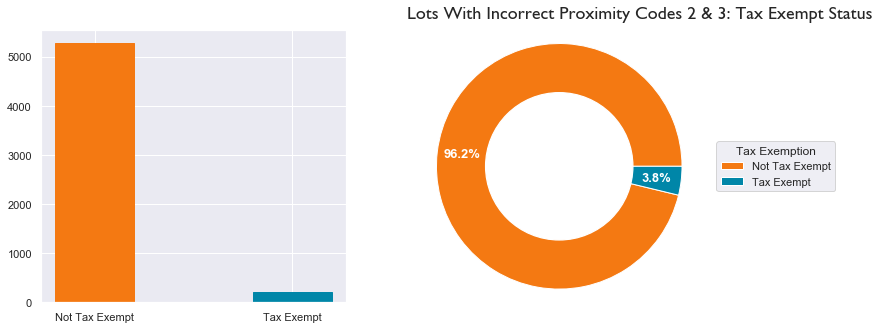

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
labels = tax_exempt_breakout23['Exempt'].to_list()
amounts = tax_exempt_breakout23['count'].to_list()
colors = ['#f47912', '#0086a8']
barlist=axs[0].bar(labels, amounts, width=.4)
barlist[0].set_color('#f47912')
barlist[1].set_color('#0086a8')

wedges, texts, autotexts = axs[1].pie(amounts, labels=labels, colors=colors, radius=1,
        autopct='%1.1f%%', shadow=False, pctdistance=.8, textprops=dict(color="w"))

axs[1].legend(wedges, labels,
          title="Tax Exemption",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=13, weight="bold")
centre_circle = plt.Circle((0,0),.6,color='white', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.title('Lots With Incorrect Proximity Codes 2 & 3: Tax Exempt Status', fontsize=18, fontname='Gill Sans', pad=12)

plt.show()

#### Part 2: ProxCode = 1 (Non-Attached Buildings)

Create a table holding only those lots/buildings where the ProxCode = 1 (non-attached buildings).

In [17]:
sql.execute('''CREATE TABLE dcp.buildings_1 AS
SELECT CAST("BBL" AS TEXT) AS bbl, 
b.bin, 
b.geom as building_geom, 
p.geom as lot_geom
FROM dcp.pluto202 p, dcp.bldg_footprints b
WHERE "ProxCode" = '1'
AND "NumBldgs" = 1
AND CAST(p."BBL" AS TEXT) = b.mpluto_bbl;
CREATE INDEX lot_geom_idx_1
  ON dcp.buildings_1
  USING GIST (lot_geom);
CREATE INDEX building_geom_idx_1
  ON dcp.buildings_1
  USING GIST (building_geom);''', cnx)
buildings_1 = pd.read_sql_query('''SELECT * FROM dcp.buildings_1;''', cnx)
buildings_1.shape[0]

162869

Get geometry for lot where ProxCode equals 1 but the building has an abutting building

In [18]:
sql.execute('''CREATE TABLE dcp.lot1_bldg AS
SELECT b1.bbl, b1.bin AS bldg1_bin, b1.building_geom, b2.bin AS footprints_bin
FROM dcp.buildings_1 b1, dcp.bldg_footprints b2
WHERE (b1.bin <> b2.bin)
AND ST_DWithin(b1.building_geom, b2.geom, 0)
AND NOT ST_Equals(b1.building_geom, b2.geom);''', cnx)
lot1_bldg = pd.read_sql_query('''SELECT * FROM dcp.lot1_bldg;''', cnx)
lot1_bldg.shape[0]

13627

Importing the geometry from the buildings characterized as standalone along with neighboring buildings shows that some actually abut other buildings (13627 of 162869 or 8.36%). Put the neighboring buildings in a table so you can import them into shapefiles and view them in ArcMap.

In [19]:
sql.execute('''CREATE TABLE dcp.lot1_neighboring_bldg AS
SELECT b2.mpluto_bbl, b2.bin, b2.geom
FROM dcp.buildings_1 b1, dcp.bldg_footprints b2
WHERE (b1.bin <> b2.bin)
AND ST_DWithin(b1.building_geom, b2.geom, 0)
AND NOT ST_Equals(b1.building_geom, b2.geom);''', cnx)
lot1_neighboring_bldg = pd.read_sql_query('''SELECT * FROM dcp.lot1_neighboring_bldg;''', cnx)
lot1_neighboring_bldg.shape[0]

13627

Break out counts of records by borough

In [20]:
boro_breakout1 = pd.read_sql_query('''SELECT "Borough", COUNT(*)
FROM dcp.lot1_neighboring_bldg l, dcp.pluto202 p
WHERE l.mpluto_bbl = CAST(p."BBL" AS TEXT)
GROUP BY "Borough";''', cnx)
boro_breakout1

,Borough,count
0,BK,4505
1,BX,2818
2,MN,1142
3,QN,3334
4,SI,1794


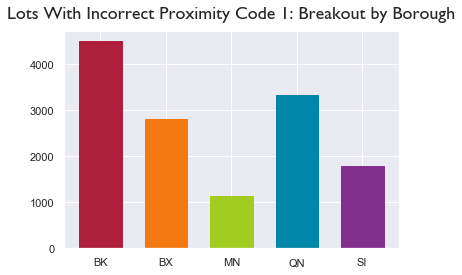

In [21]:
rcParams['figure.figsize'] = 6, 4
xlist = boro_breakout1['Borough'].to_list()
ylist = boro_breakout1['count'].to_list()
barlist=plt.bar(xlist, ylist, width=.65)
barlist[0].set_color('#ad1f3c')
barlist[1].set_color('#f47912')
barlist[2].set_color('#a2cc22')
barlist[3].set_color('#0086a8')
barlist[4].set_color('#832f8e')
plt.title('Lots With Incorrect Proximity Code 1: Breakout by Borough', fontsize=18, fontname='Gill Sans', pad=12)
plt.show()

Break out counts of records by land use code

In [22]:
landuse_breakout1 = pd.read_sql_query('''SELECT "LandUse", COALESCE(def, 'NULL') AS def, COUNT(*)
FROM dcp.lot1_neighboring_bldg l, dcp.pluto202 p
LEFT JOIN dcp.landuse_definitions d
ON p."LandUse" = d.landuse
WHERE l.mpluto_bbl = CAST(p."BBL" AS TEXT)
GROUP BY "LandUse", def''', cnx)
landuse_breakout1

,LandUse,def,count
0,01,One and Two Family Buildings,5653
1,02,Multi-Family Walkup Buildings,2986
2,03,Multi-Family Elevator Buildings,506
3,04,Mixed Residential and Commercial,1554
4,05,Commercial and Office,1166
5,06,Industrial and Manufacturing,675
6,07,Transportation and Utility,250
7,08,Public Facilities and Institutions,467
8,09,Open Space and Outdoor Recreation,5
9,10,Parking Facilities,201


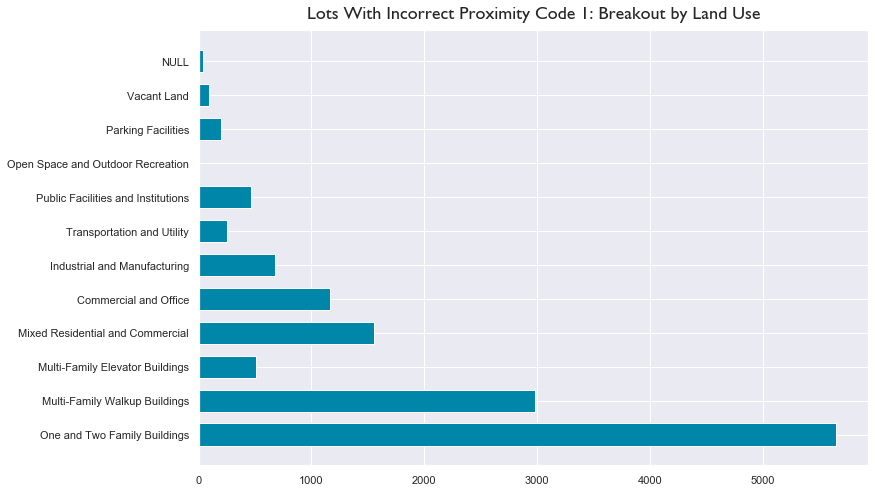

In [23]:
rcParams['figure.figsize'] = 12, 8
xlist = landuse_breakout1['def'].to_list()
ylist = landuse_breakout1['count'].to_list()
barlist=plt.barh(xlist, ylist, height=.65, color='#0086a8')
plt.xticks()
plt.title('Lots With Incorrect Proximity Code 1: Breakout by Land Use', fontsize=18, fontname='Gill Sans', pad=12)
plt.show()

Tax exempt or not?

In [24]:
tax_exempt_breakout1 = pd.read_sql_query('''SELECT
CASE 
	WHEN "ExemptTot" = "AssessTot" THEN 'Tax Exempt'
	ELSE 'Not Tax Exempt'
END AS "Exempt",
COUNT(*)
FROM dcp.lot1_neighboring_bldg l, dcp.pluto202 p
WHERE l.mpluto_bbl = CAST(p."BBL" AS TEXT)
GROUP BY 1;''', cnx)
tax_exempt_breakout1

,Exempt,count
0,Not Tax Exempt,12943
1,Tax Exempt,650


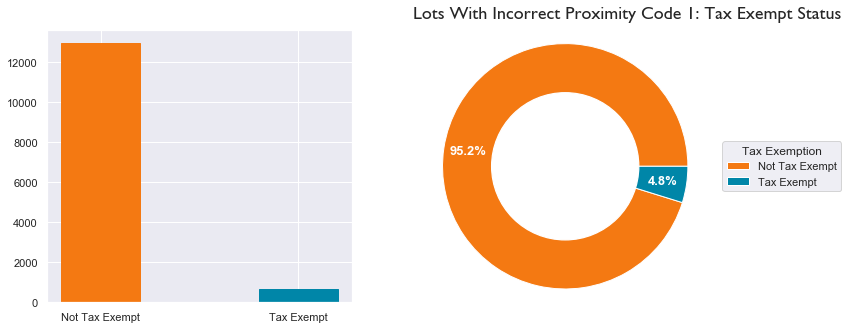

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
labels = tax_exempt_breakout1['Exempt'].to_list()
amounts = tax_exempt_breakout1['count'].to_list()
colors = ['#f47912', '#0086a8']
barlist=axs[0].bar(labels, amounts, width=.4)
barlist[0].set_color('#f47912')
barlist[1].set_color('#0086a8')

wedges, texts, autotexts = axs[1].pie(amounts, labels=labels, colors=colors, radius=1,
        autopct='%1.1f%%', shadow=False, pctdistance=.8, textprops=dict(color="w"))

axs[1].legend(wedges, labels,
          title="Tax Exemption",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=13, weight="bold")
centre_circle = plt.Circle((0,0),.6,color='white', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.title('Lots With Incorrect Proximity Code 1: Tax Exempt Status', fontsize=18, fontname='Gill Sans', pad=12)

plt.show()